In [13]:
import numpy as np
import timeit

# BiotSavart Algorithm Tests

Generate points to run through the different algorithms

In [14]:
# Define the filament shape
circle = lambda t : [np.cos(t), np.sin(t), t * 0]
dCircle = lambda t : [-np.sin(t), np.cos(t), t * 0]
circlePoints = np.linspace(0,2*np.pi,1000)

# Calculate points on the circle to use
s = np.array(circle(circlePoints))
ds = np.array(dCircle(circlePoints))

# Find points to calculate the Velocity Field at around the circle
# In this case, it will be points along the x-axis through the circle at y=0 and z=0
domain = np.linspace(-1.5, 1.5, 1000)
posFunc = lambda t: [ t, t*0, t*0 ]
pos = np.array( posFunc( domain ) )

## Algorithm One
This is the first algorithm that I came up with. It works fine, but it's so slow.

In [15]:
class AlgorithmOne():
    @staticmethod
    def BiotSavartPoint(curve, curveTangent, curvePoint):
        s = range(0,len(curve[0]))
        dv = []
        for c in s:
            num = np.cross( curveTangent[:,c], curvePoint - curve[:,c] )
            den = np.linalg.norm(curvePoint - curve[:,c]) ** 3
            dv.append( np.divide(num,den) )

        dv = np.array(dv)

        v = np.trapz([dv[:,0],dv[:,1],dv[:,2]], s)
        return v
    
    @staticmethod
    def BiotSavartPoints(curve, curveTangent, curvePoints):
        biotSavartPoints = []

        for i in range( len(curvePoints[0,:]) ):
            curvePoint = curvePoints[:,i]
            biotSavartPoints.append( AlgorithmOne.BiotSavartPoint( curve, curveTangent, curvePoint ) )
            
        return np.array( biotSavartPoints )

In [16]:
startTime = timeit.default_timer()

bsPtsAlg1 = AlgorithmOne.BiotSavartPoints( s, ds, pos )

stopTime = timeit.default_timer()

print(f'Code Time: {stopTime - startTime}')

Code Time: 39.361670065998624


## Algorithm Two


In [17]:
class AlgorithmTwo():
    @staticmethod
    def BiotSavart( curve: np.array, curveTangent: np.array, fieldPoints: np.array ):
        pointFieldStrength = np.zeros( (len(curve[0,:]), len( fieldPoints[:,0] ), len( fieldPoints[0,:] ) ) )

        s = range( len(curve[0,:]) )

        for i in s:
            pointDistances =  fieldPoints - curve[:,i].reshape(-1,1)

            pointNorms = np.linalg.norm(pointDistances, axis=0)
            pointNormsCubed = np.power( pointNorms, 3)

            crossProduct = ( np.cross(curveTangent[:,i], pointDistances.T ) ).T
            pointFieldStrength[i,:,:] = crossProduct / pointNormsCubed

        v = np.trapz( pointFieldStrength, s , axis=0)
        return v

In [18]:
bsPtsAlg2 = AlgorithmTwo.BiotSavart( s, ds, pos )

In [19]:
startTime = timeit.default_timer()

bsPtsAlg2 = AlgorithmTwo.BiotSavart( s, ds, pos )

stopTime = timeit.default_timer()

print(f'Code Time: {stopTime - startTime}')

Code Time: 0.174648216998321


## Algorithm Three

Exploring the Kappa Binormal approximation

### Attempt 1

In [20]:
import matplotlib.pyplot as plt

# Make the Pringle function
P = lambda t: [ np.cos(t), np.sin(t), np.square(np.cos(t)) - np.square(np.sin(t)) ]
dP = lambda t: [ -np.sin(t), np.cos(t), 2*np.cos(t)*(-1)*np.sin(t) - 2*np.sin(t)*np.cos(t) ]
PPoints = np.linspace( 0, 2 * np.pi, 200 )

# Find values on the pringle
s = np.array( P(PPoints) )
ds = np.array( dP(PPoints) )

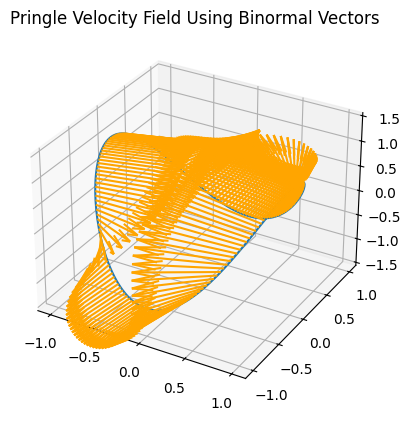

In [21]:
T = np.gradient(s)[1]
N = np.gradient(T)[1]
B = np.cross(T,N, axisa=0, axisb=0, axisc=0)

Kappa = np.divide( np.linalg.norm( B ), np.power( np.linalg.norm(T),3 ) )

KBApprox = np.multiply(Kappa, B)

# Create a 3D quiver plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(s[0,:], s[1,:], s[2,:], KBApprox[0,:], KBApprox[1,:], KBApprox[2,:], normalize=True, color='orange')

ax.set_zlim([-1.5,1.5])
ax.plot( s[0,:], s[1,:], s[2,:] )
plt.title('Pringle Velocity Field Using Binormal Vectors')

plt.show()